## Libraries and directory

In [1]:
#import packages, there might be some extras
import time
import os
import platform

import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, accuracy_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
import keras.utils
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix
from IPython.display import HTML


import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import imageio
from tqdm import tqdm
import random

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 'large'


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/Progetto_gait_recognition/dataset-20240610T153249Z-001.zip" -d "/content"

Archive:  /content/drive/MyDrive/Progetto_gait_recognition/dataset-20240610T153249Z-001.zip
  inflating: /content/dataset/subject4/lurching/trial1/Sbj4_lurching_T1_P.csv  
  inflating: /content/dataset/subject4/lurching/trial19/Sbj4_lurching_T19_S.csv  
  inflating: /content/dataset/subject4/lurching/trial10/Sbj4_lurching_T10_P.csv  
  inflating: /content/dataset/subject4/lurching/trial20/Sbj4_lurching_T20_S.csv  
  inflating: /content/dataset/subject4/lurching/trial4/Sbj4_lurching_T4_S.csv  
  inflating: /content/dataset/subject4/lurching/trial10/Sbj4_lurching_T10_S.csv  
  inflating: /content/dataset/subject4/lurching/trial9/Sbj4_lurching_T9_S.csv  
  inflating: /content/dataset/subject4/lurching/trial6/Sbj4_lurching_T6_S.csv  
  inflating: /content/dataset/subject4/lurching/trial17/Sbj4_lurching_T17_S.csv  
  inflating: /content/dataset/subject4/lurching/trial18/Sbj4_lurching_T18_P.csv  
  inflating: /content/dataset/subject4/lurching/trial11/Sbj4_lurching_T11_S.csv  
  inflating: /

In [4]:
if platform.system() == "Darwin":
    root_directory_work = '/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition'
else:
    root_directory = '/content'
    root_directory_work = '/content/drive/MyDrive/Progetto_gait_recognition'

print('root directory is ' + root_directory)

root directory is /content


## Train - Test Split


In [5]:
# Create a dataframe containing all the files and the labels from the reference file
reference_df = pd.read_csv('/content/drive/MyDrive/Progetto_gait_recognition/reference_document.csv',
                           header=None, names=['Name_file', 'Path_from_Root', 'Type_of_data', 'Type_of_gait', 'Label'])

reference_df = reference_df.iloc[1:]                            # fa iniziare il numero di colonne da 1 al posto che da zero
reference_df['Label'] = reference_df['Label'].astype(int)

def process_string(r):
    compl_type = r[:-6]
    return compl_type

reference_df['Complete_type'] = reference_df.apply(lambda row: process_string(row['Name_file']), axis=1)

def complete_path(row):
  complete_path = root_directory + '/dataset/' + row['Path_from_Root'] + row['Name_file']
  return complete_path

reference_df['Complete_path'] = reference_df.apply(complete_path, axis=1)

reference_df

,Name_file,Path_from_Root,Type_of_data,Type_of_gait,Label,Complete_type,Complete_path
1,Sbj9_antalgic_T2_S.csv,subject9/antalgic/trial2/,skeleton,antalgic,0,Sbj9_antalgic_T2,/content/dataset/subject9/antalgic/trial2/Sbj9...
2,Sbj9_antalgic_T2_P.csv,subject9/antalgic/trial2/,pressure,antalgic,0,Sbj9_antalgic_T2,/content/dataset/subject9/antalgic/trial2/Sbj9...
3,Sbj9_antalgic_T8_S.csv,subject9/antalgic/trial8/,skeleton,antalgic,0,Sbj9_antalgic_T8,/content/dataset/subject9/antalgic/trial8/Sbj9...
4,Sbj9_antalgic_T8_P.csv,subject9/antalgic/trial8/,pressure,antalgic,0,Sbj9_antalgic_T8,/content/dataset/subject9/antalgic/trial8/Sbj9...
5,Sbj9_antalgic_T14_P.csv,subject9/antalgic/trial14/,pressure,antalgic,0,Sbj9_antalgic_T14,/content/dataset/subject9/antalgic/trial14/Sbj...
...,...,...,...,...,...,...,...
2876,Sbj8_normal_T17_S.csv,subject8/normal/trial17/,skeleton,normal,2,Sbj8_normal_T17,/content/dataset/subject8/normal/trial17/Sbj8_...
2877,Sbj8_normal_T10_P.csv,subject8/normal/trial10/,pressure,normal,2,Sbj8_normal_T10,/content/dataset/subject8/normal/trial10/Sbj8_...
2878,Sbj8_normal_T10_S.csv,subject8/normal/trial10/,skeleton,normal,2,Sbj8_normal_T10,/content/dataset/subject8/normal/trial10/Sbj8_...
2879,Sbj8_normal_T6_P.csv,subject8/normal/trial6/,pressure,normal,2,Sbj8_normal_T6,/content/dataset/subject8/normal/trial6/Sbj8_n...


In [6]:
joint_sk_p_df = reference_df.groupby('Complete_type').agg({
    'Complete_path': list,
    'Label': 'first'
    }).reset_index()

joint_sk_p_df['Label'] = joint_sk_p_df['Label'].astype(int)
joint_sk_p_df['Subject'] = joint_sk_p_df['Complete_type'].str[:5].str.replace('_', '')

joint_sk_p_df

,Complete_type,Complete_path,Label,Subject
0,Sbj10_antalgic_T1,[/content/dataset/subject10/antalgic/trial1/Sb...,0,Sbj10
1,Sbj10_antalgic_T10,[/content/dataset/subject10/antalgic/trial10/S...,0,Sbj10
2,Sbj10_antalgic_T11,[/content/dataset/subject10/antalgic/trial11/S...,0,Sbj10
3,Sbj10_antalgic_T12,[/content/dataset/subject10/antalgic/trial12/S...,0,Sbj10
4,Sbj10_antalgic_T13,[/content/dataset/subject10/antalgic/trial13/S...,0,Sbj10
...,...,...,...,...
1435,Sbj9_trendelenburg_T5,[/content/dataset/subject9/trendelenburg/trial...,5,Sbj9
1436,Sbj9_trendelenburg_T6,[/content/dataset/subject9/trendelenburg/trial...,5,Sbj9
1437,Sbj9_trendelenburg_T7,[/content/dataset/subject9/trendelenburg/trial...,5,Sbj9
1438,Sbj9_trendelenburg_T8,[/content/dataset/subject9/trendelenburg/trial...,5,Sbj9


In [7]:
# recall
# LABELS = np.array(['antalgic', 'lurching', 'normal', 'steppage', 'stifflegged', 'trendelenburg'])

# train_val_test split
train = joint_sk_p_df[~joint_sk_p_df['Complete_type'].str.startswith('Sbj12')]
test = joint_sk_p_df[joint_sk_p_df['Complete_type'].str.startswith('Sbj12')]



#frequence counts
print("Train")
print(train['Label'].value_counts(), '\n')
print("Test")
print(test['Label'].value_counts(), '\n')

Train
Label
0    220
1    220
2    220
3    220
4    220
5    220
Name: count, dtype: int64 

Test
Label
0    20
1    20
2    20
3    20
4    20
5    20
Name: count, dtype: int64 



# Step by step

## Load and preprocessing

In [8]:
def file_type(lista):

    ele1 = lista[0]

    if ele1[-5:]=='S.csv':
        sk = lista[0]
        p = lista[1]
    else:
        sk = lista[1]
        p = lista[0]

    return sk, p

In [9]:
name_gait = ['Antalgic', 'Lurching', 'Normal', 'Steppage', 'Stiff-legged', 'Trendelenburg']

test.reset_index(drop=True, inplace=True)
random_sample = random.randint(0, len(test['Complete_path']))
print("The randomply extracted test sample is the number:", random_sample, '\n')

sk_name, p_name = file_type(test['Complete_path'][random_sample])
true_label = name_gait[test['Label'][random_sample]]

print('True label:', true_label, '\n')
print(sk_name)
print(p_name)


The randomply extracted test sample is the number: 31 

True label: Lurching 

/content/dataset/subject12/lurching/trial2/Sbj12_lurching_T2_S.csv
/content/dataset/subject12/lurching/trial2/Sbj12_lurching_T2_P.csv


#### Skeleton

Original shape  (338, 32, 3)



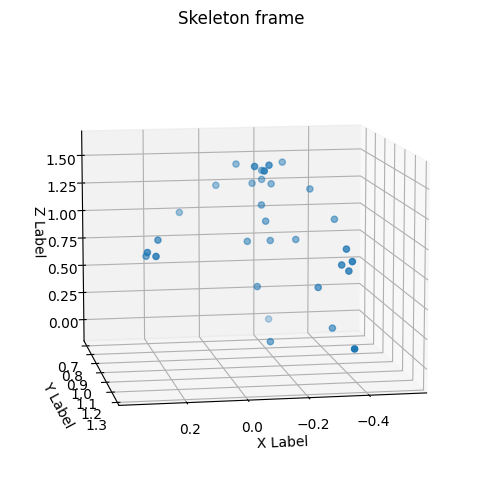

In [26]:
def load_data_sk_final(complete_path, load=True):

    if load:
        complete_path = complete_path.decode()

    df_skelly = pd.read_csv(complete_path, header=None)
    df_skelly = df_skelly.drop([df_skelly.columns[0],df_skelly.columns[-1]], axis=1)

    data = df_skelly.to_numpy().reshape((-1,32,3))

    return data.squeeze()


sk_data = load_data_sk_final(sk_name, load=False)
print('Original shape ', sk_data.shape)
print()

frame = random.randint(0, sk_data.shape[0])
plotdata = sk_data[frame]

min_x = np.min(plotdata[:, 0])
max_x = np.max(plotdata[:, 0])
min_y = np.min(plotdata[:, 1])
max_y = np.max(plotdata[:, 1])
min_z = np.min(plotdata[:, 2])
max_z = np.max(plotdata[:, 2])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('Skeleton frame')
ax.view_init(elev=10, azim=80)
ax.invert_xaxis()
ax.set_xlim(min_x-0.15, max_x+0.15)
ax.set_ylim(min_y-0.15, max_y+0.15)
ax.set_zlim(min_z-0.15, max_z+0.15)
plt.show()

# # Create a function to update the plot
# def update(frame, data):
#     ax.cla()
#     sc = ax.scatter(data[frame,:, 0], data[frame,:, 1], data[frame,:, 2])
#     ax.set_xlim(min_x-0.2, max_x+0.2)
#     # ax.set_ylim(min_y-0.1, max_y+0.1)
#     ax.set_zlim(min_z-0.2, max_z+0.2)
#     ax.invert_xaxis()
#     return sc

# # Create the animation
# ani = FuncAnimation(fig, update, frames=len(sk_data), fargs=(sk_data,), blit=False)

# # Display the animation
# load_sk_gif = HTML(ani.to_jshtml())

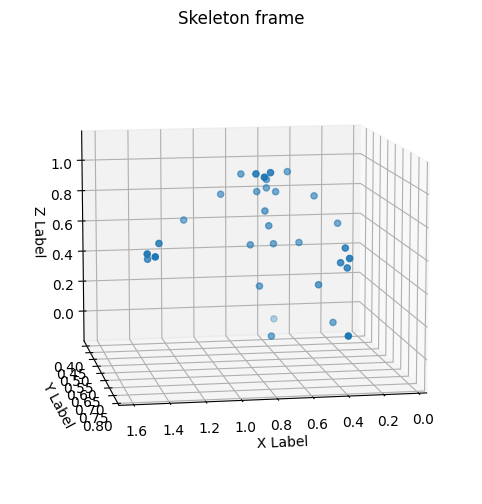

In [27]:
def normalize_data_sk_final(data):
    # Amplitude estimate for each axes
    norm_factor_x = np.percentile(data[:, :, 0], 95) - np.percentile(data[:, :, 0], 5)
    norm_factor_y = np.percentile(data[:, :, 1], 95) - np.percentile(data[:, :, 1], 5)
    norm_factor_z = np.percentile(data[:, :, 2], 95) - np.percentile(data[:, :, 2], 5)

    data[:, :, 0] = (data[:, :, 0] - np.percentile(data[:, :, 0], 5)) / norm_factor_x
    data[:, :, 1] = (data[:, :, 1] - np.percentile(data[:, :, 1], 5)) / norm_factor_y
    data[:, :, 2] = (data[:, :, 2] - np.percentile(data[:, :, 2], 5)) / norm_factor_z

    return data


sk_data_norm = normalize_data_sk_final(sk_data)
plotdata = sk_data_norm[frame]

min_x = np.min(plotdata[:, 0])
max_x = np.max(plotdata[:, 0])
min_y = np.min(plotdata[:, 1])
max_y = np.max(plotdata[:, 1])
min_z = np.min(plotdata[:, 2])
max_z = np.max(plotdata[:, 2])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('Skeleton frame')
ax.view_init(elev=10, azim=80)
ax.invert_xaxis()
ax.set_xlim(min_x-0.25, max_x+0.25)
ax.set_ylim(min_y-0.15, max_y+0.15)
ax.set_zlim(min_z-0.15, max_z+0.15)
plt.show()


# # Create a function to update the plot
# def update(frame, data):
#     ax.cla()
#     sc = ax.scatter(data[frame,:, 0], data[frame,:, 1], data[frame,:, 2])
#     ax.invert_xaxis()
#     return sc

# # Create the animation
# ani = FuncAnimation(fig, update, frames=len(sk_data_joints_norm), fargs=(sk_data_joints_norm,), blit=False)

# # Display the animation
# sk_data_joints_norm_gif = HTML(ani.to_jshtml())

In [12]:
joint_dataframe = {'SPINE' : ['0 - PELVIS', '1 - SPINE_NAVAL', '2 - SPINE_CHEST', '3 - NECK', '', '', ''],
                   'LEFT ARM': ['4 - CLAVICLE_LEFT', '5 - SHOULDER_LEFT', '6 - ELBOW_LEFT', '7 - WRIST_LEFT', '8 - HAND_LEFT', '9 - HANDTIP_LEFT', '10 - THUMB_LEFT'],
                   'RIGHT ARM': ['11 - CLAVICLE_RIGHT', '12 - SHOULDER_RIGHT', '13 - ELBOW_RIGHT', '14 - WRIST_RIGHT', '15 - HAND_RIGHT', '16 - HANDTIP_RIGHT', '17 - THUMB_RIGHT'],
                   'LEFT LEG': ['18 - HIP_LEFT', '19 - KNEE_LEFT', '20 - ANKLE_LEFT', '21 - FOOT_LEFT', '', '', ''],
                   'RIGHT LEG': ['22 - HIP_RIGHT', '23 - KNEE_RIGHT', '24 - ANKLE_RIGHT', '25 - FOOT_RIGHT', '', '', ''],
                   'HEAD': ['26 - HEAD', '27 - NOSE', '28 - EYE_LEFT', '29 - EAR_LEFT', '30 - EYE_RIGHT', '31 - EAR_RIGHT', '']}

joint_df = pd.DataFrame(joint_dataframe)
joint_df

,SPINE,LEFT ARM,RIGHT ARM,LEFT LEG,RIGHT LEG,HEAD
0,0 - PELVIS,4 - CLAVICLE_LEFT,11 - CLAVICLE_RIGHT,18 - HIP_LEFT,22 - HIP_RIGHT,26 - HEAD
1,1 - SPINE_NAVAL,5 - SHOULDER_LEFT,12 - SHOULDER_RIGHT,19 - KNEE_LEFT,23 - KNEE_RIGHT,27 - NOSE
2,2 - SPINE_CHEST,6 - ELBOW_LEFT,13 - ELBOW_RIGHT,20 - ANKLE_LEFT,24 - ANKLE_RIGHT,28 - EYE_LEFT
3,3 - NECK,7 - WRIST_LEFT,14 - WRIST_RIGHT,21 - FOOT_LEFT,25 - FOOT_RIGHT,29 - EAR_LEFT
4,,8 - HAND_LEFT,15 - HAND_RIGHT,,,30 - EYE_RIGHT
5,,9 - HANDTIP_LEFT,16 - HANDTIP_RIGHT,,,31 - EAR_RIGHT
6,,10 - THUMB_LEFT,17 - THUMB_RIGHT,,,


Shape after removing joints  (338, 12, 3)



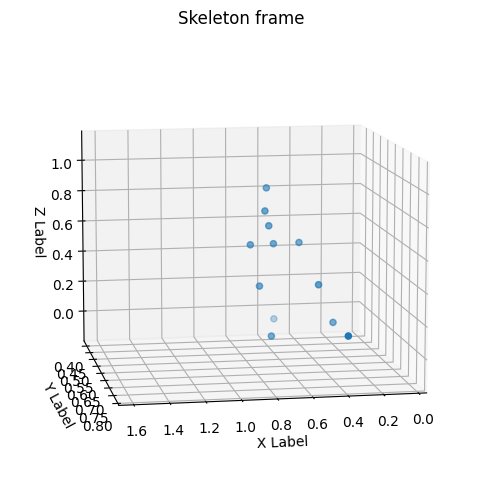

In [28]:
def remove_joints_final(data, joint_list, load=True):

    mask=np.ones(32,dtype=bool)

    if len(joint_list) == 0:
        pass

    else:
        for joint in joint_list:

            if load:
                joint = joint.decode()

            if type(joint) == str:

                if joint == 'head':
                    joint_num = [26,27,28,29,30,31]

                elif joint == 'rleg':
                    joint_num = [22,23,24,25]

                elif joint == 'lleg':
                    joint_num = [18,19,20,21]

                elif joint == 'rarm':
                    joint_num = [11,12,13,14,15,16,17]

                elif joint == 'larm':
                    joint_num = [4,5,6,7,8,9,10]

                elif joint == 'spine':
                    joint_num = [0,1,2,3]

                else:
                    print('unknown keyword, returning to default')
                    mask=np.ones(len(data),dtype=bool)
                    break


            else:
                joint_num = [joint]


            for j in joint_num:
                mask[j]=0

    filtered_skelly = data[:, mask, :]

    return filtered_skelly


sk_data_norm_joints = remove_joints_final(sk_data_norm, ['larm', 'rarm', 'head'], load=False)
print('Shape after removing joints ', sk_data_norm_joints.shape)
print()

plotdata = sk_data_norm_joints[frame]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('Skeleton frame')
ax.view_init(elev=10, azim=80)
ax.invert_xaxis()
ax.set_xlim(min_x-0.25, max_x+0.25)
ax.set_ylim(min_y-0.15, max_y+0.15)
ax.set_zlim(min_z-0.15, max_z+0.15)
plt.show()

# # Create the animation
# ani = FuncAnimation(fig, update, frames=len(sk_data_joints), fargs=(sk_data_joints,), blit=False)

# # Display the animation
# load_sk_joints_gif = HTML(ani.to_jshtml())

In [14]:
def load_prep_sk_final(complete_path, joints = ['rarm', 'larm', 'head'], load = True):
    data = load_data_sk_final(complete_path, load)
    data = normalize_data_sk_final(data)
    data = remove_joints_final(data, joints, load = False)

    return data.astype(np.float32)

#### Pressure

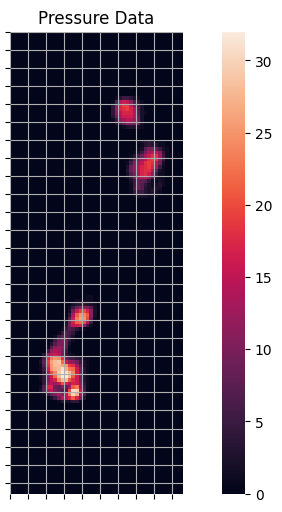

In [29]:
def load_data_ps_final(complete_path, load=True):

    if load:
      complete_path = complete_path.decode()

    pressure_data = pd.read_csv(complete_path, header=None).to_numpy()

    return pressure_data.squeeze()


ps_data = load_data_ps_final(p_name, load=False)

fig, ax = plt.subplots()
sns.heatmap(ps_data, square=True, linewidths=0, ax=ax)
ax.set_title('Pressure Data')

ax.set_xticks(np.arange(0, ps_data.shape[1], 5))
ax.set_yticks(np.arange(0, ps_data.shape[0], 5))

plt.show()

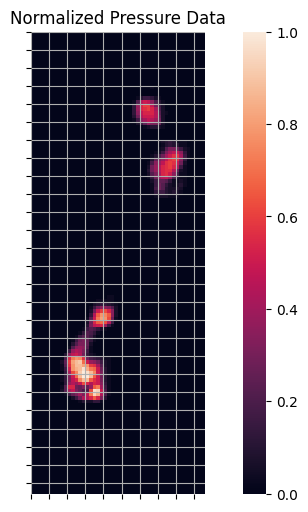

In [30]:
def normalize_data_ps_final(data):
    massimo = np.max(data)
    data = data / massimo
    return data


ps_data_norm = normalize_data_ps_final(ps_data)

fig, ax = plt.subplots()
sns.heatmap(ps_data_norm, square=True, linewidths=0, ax=ax)
ax.set_title('Normalized Pressure Data')

ax.set_xticks(np.arange(0, ps_data.shape[1], 5))
ax.set_yticks(np.arange(0, ps_data.shape[0], 5))

plt.show()

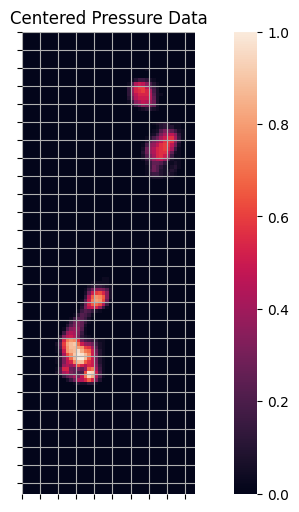

In [31]:
def baricenter_final(data):
    # Compute the weighted average (barycenter) along each dimension
    y_barycenter = np.average(np.arange(data.shape[0]), weights=np.sum(data, axis=1))
    x_barycenter = np.average(np.arange(data.shape[1]), weights=np.sum(data, axis=0))

    # print("Barycenter coordinates (x,y) = ",x_barycenter,y_barycenter)
    # print("Center image (x,y) = ", data.shape[1]/2, data.shape[0]/2)

    # Compute the distances between each point and the barycenter
    shift_x = -(x_barycenter - data.shape[1]/2)
    shift_y = -(y_barycenter - data.shape[0]/2)

    # Shift the foot pressure matrix to be centered on the barycenter
    shifted_matrix = np.roll(data, int(shift_x), axis=1)
    shifted_matrix = np.roll(shifted_matrix, int(shift_y), axis=0)

    return shifted_matrix


ps_data_norm_center = baricenter_final(ps_data_norm)

fig, ax = plt.subplots()
sns.heatmap(ps_data_norm_center, square=True, linewidths=0, ax=ax)
ax.set_title('Centered Pressure Data')

ax.set_xticks(np.arange(0, ps_data.shape[1], 5))
ax.set_yticks(np.arange(0, ps_data.shape[0], 5))

plt.show()

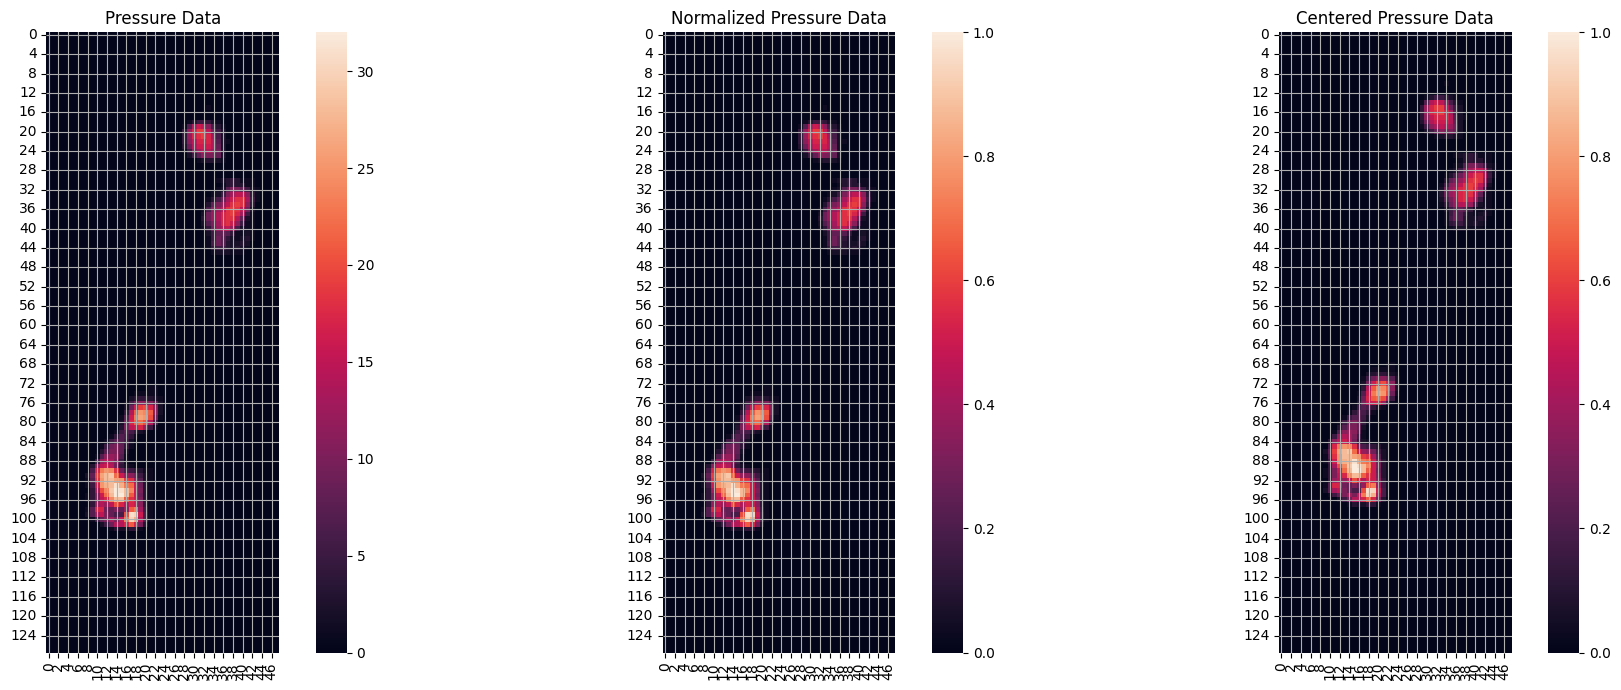

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))


sns.heatmap(ps_data, square=True, linewidths=0, ax=axs[0])
axs[0].set_title('Pressure Data')
ax.set_xticks(np.arange(0, ps_data.shape[1], 5))
ax.set_yticks(np.arange(0, ps_data.shape[0], 5))


sns.heatmap(ps_data_norm, square=True, linewidths=0, ax=axs[1])
axs[1].set_title('Normalized Pressure Data')
ax.set_xticks(np.arange(0, ps_data.shape[1], 5))
ax.set_yticks(np.arange(0, ps_data.shape[0], 5))


sns.heatmap(ps_data_norm_center, square=True, linewidths=0, ax=axs[2])
axs[2].set_title('Centered Pressure Data')
ax.set_xticks(np.arange(0, ps_data.shape[1], 5))
ax.set_yticks(np.arange(0, ps_data.shape[0], 5))

plt.tight_layout()
plt.show()

In [33]:
def load_prep_ps_final(complete_path):
    data = load_data_ps_final(complete_path, load=True)
    data = normalize_data_ps_final(data)
    data = baricenter_final(data)

    return data.astype(np.float32)

### Complete

In [20]:
def load_prep_final(lista):

    ele1 = lista[0].decode()

    if ele1[-5:]=='S.csv':
        sk = lista[0]
        p = lista[1]
    else:
        sk = lista[1]
        p = lista[0]

    skeletron = load_prep_sk_final(sk).reshape(-1)
    pressure = load_prep_ps_final(p).reshape(-1)

    joint_vector = np.concatenate((skeletron, pressure))

    return joint_vector

sk_p_data = load_prep_final([sk_name.encode(), p_name.encode()])

Shape Skleton data: (50, 12, 3)
Shape Pressure data: (128, 48)


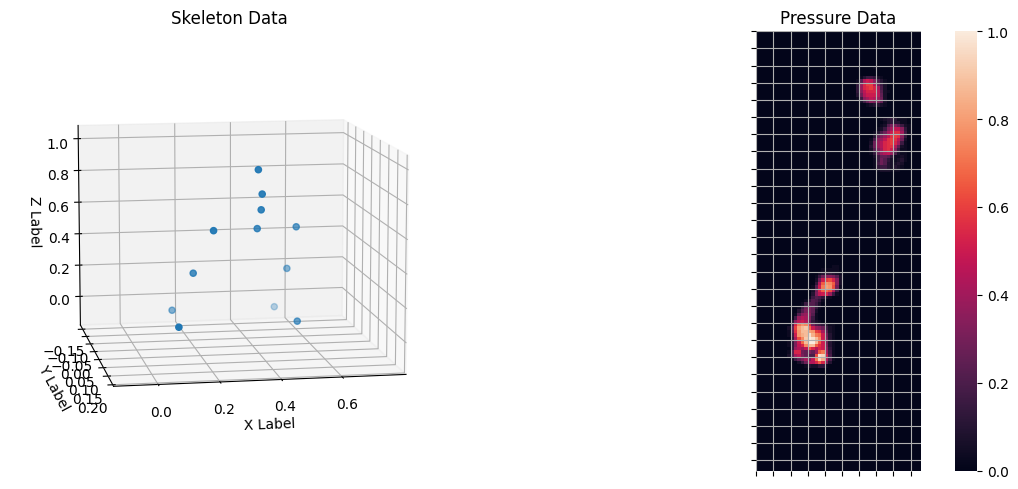

In [34]:
def random_crop_final(data, target_size=50, center_crop=False):

    sk = data[:-6144]
    p = data[-6144:]

    sk = sk.reshape(-1, 12, 3)

    noise_time_begin = int(sk.shape[0]/2) - 10
    noise_time_end = 5

    # remove initial and final frames that we consider as noise
    start = noise_time_begin
    end = sk.shape[0] - noise_time_end

    sk = sk[start:end, :]

    N = sk.shape[0]

    # Random Crop (always centered if center_crop=True)
    if center_crop:
        from_ = int((N / 2) - (target_size / 2))
        # print('Start of the crop: ', from_)
    else:
        from_ = np.random.randint(0, np.floor(N - target_size))
        # print('Start of the crop: ', from_)

    sk_cropped = sk[from_:from_ + target_size]
    sk_cropped = sk_cropped.reshape(-1)

    final_vector = np.concatenate((sk_cropped, p))

    return final_vector




sk_p_data_crop = random_crop_final(sk_p_data)
sk_data_crop = sk_p_data_crop[:-6144].reshape(-1, 12, 3)
p_data_crop = sk_p_data_crop[-6144:].reshape(128, 48)
print('Shape Skleton data:', sk_data_crop.shape)
print('Shape Pressure data:', p_data_crop.shape)



plotdata = sk_data_norm_joints[25]

min_x = np.min(plotdata[:, 0])
max_x = np.max(plotdata[:, 0])
min_y = np.min(plotdata[:, 1])
max_y = np.max(plotdata[:, 1])
min_z = np.min(plotdata[:, 2])
max_z = np.max(plotdata[:, 2])

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121, projection='3d')
sc = ax1.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax1.set_xlabel('X Label')
ax1.set_ylabel('Y Label')
ax1.set_zlabel('Z Label')
ax1.set_title('Skeleton Data')
ax1.set_xlim(min_x-0.25, max_x+0.25)
ax1.set_ylim(min_y-0.15, max_y+0.15)
ax1.set_zlim(min_z-0.15, max_z+0.15)
ax1.view_init(elev=10, azim=80)
ax1.invert_xaxis()

ax2 = fig.add_subplot(122)
sns.heatmap(p_data_crop, square=True, linewidths=0, ax=ax2)
ax2.set_title('Pressure Data')
ax2.set_xticks(np.arange(0, p_data_crop.shape[1], 5))
ax2.set_yticks(np.arange(0, p_data_crop.shape[0], 5))

plt.tight_layout()

plt.show()

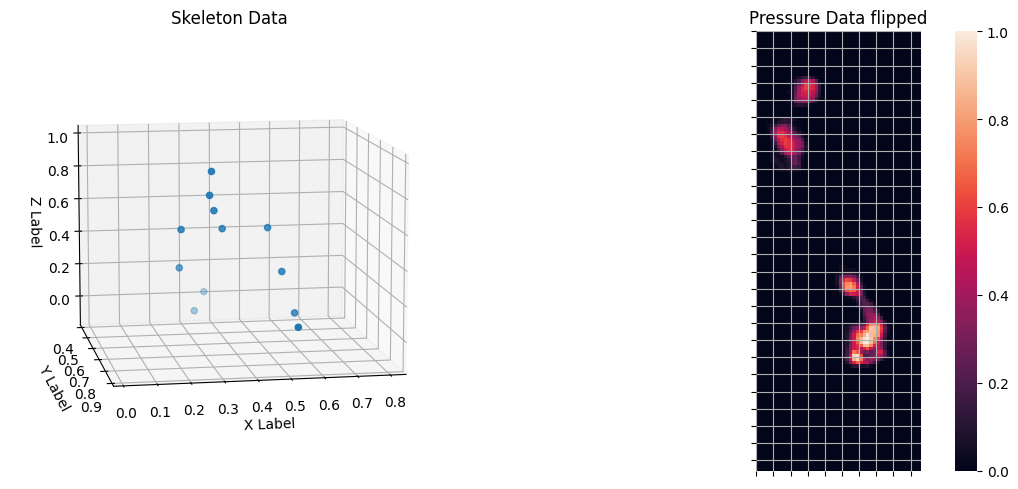

In [35]:
def random_flip_final(data, flip_prob=0.5):

    sk = data[:-6144]
    p = data[-6144:]

    sk = sk.reshape(-1, 12, 3)
    p = p.reshape(128, 48)

    x_data = sk[:, :, 0]
    y_data = sk[:, :, 1]
    z_data = sk[:, :, 2]

    prob = np.random.rand()

    if prob < flip_prob:
        x_data = 1 - x_data
        p = np.flip(p, axis=1)

    sk_flipped = np.dstack((x_data, y_data, z_data))

    sk_flipped = sk_flipped.reshape(-1)
    p_flipped = p.reshape(-1)

    final_vector = np.concatenate((sk_flipped, p_flipped))

    return final_vector




sk_p_data_crop_flip = random_flip_final(sk_p_data_crop, flip_prob=1)
sk_data_crop_flip = sk_p_data_crop_flip[:-6144].reshape(-1, 12, 3)
p_data_crop_flip = sk_p_data_crop_flip[-6144:].reshape(128, 48)

plotdata = sk_data_crop_flip[25]

min_x = np.min(plotdata[:, 0])
max_x = np.max(plotdata[:, 0])
min_y = np.min(plotdata[:, 1])
max_y = np.max(plotdata[:, 1])
min_z = np.min(plotdata[:, 2])
max_z = np.max(plotdata[:, 2])

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121, projection='3d')
sc = ax1.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax1.set_xlabel('X Label')
ax1.set_ylabel('Y Label')
ax1.set_zlabel('Z Label')
ax1.set_title('Skeleton Data')
ax1.set_xlim(min_x-0.25, max_x+0.25)
ax1.set_ylim(min_y-0.15, max_y+0.15)
ax1.set_zlim(min_z-0.15, max_z+0.15)
ax1.view_init(elev=10, azim=80)
ax1.invert_xaxis()

ax2 = fig.add_subplot(122)
sns.heatmap(p_data_crop_flip, square=True, linewidths=0, ax=ax2)
ax2.set_title('Pressure Data flipped')
ax2.set_xticks(np.arange(0, p_data_crop_flip.shape[1], 5))
ax2.set_yticks(np.arange(0, p_data_crop_flip.shape[0], 5))

plt.tight_layout()

plt.show()

In [36]:
sk_p_data_crop_flip = random_flip_final(sk_p_data_crop)

## Model Prediction

In [37]:
step_3_model = tf.keras.models.load_model(root_directory_work + '/Cross_validation_full_model/full_model.h5')

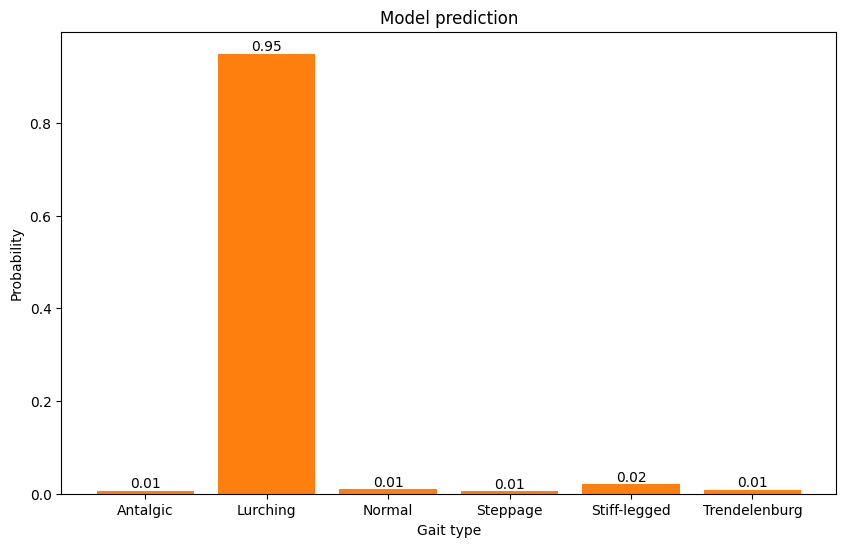


The predected label from the model is: Lurching 

The true label is: Lurching
The prediction is correct.


In [38]:
# compute predicted labels
model_input = sk_p_data_crop_flip[np.newaxis, :]

output_vector = step_3_model.predict(model_input, verbose=0)
predicted_label = name_gait[np.argmax(output_vector)]

plt.bar(name_gait, output_vector.reshape(-1))
plt.xlabel('Gait type')
plt.ylabel('Probability')
plt.title('Model prediction')
plt.grid(False)
plt.bar_label(plt.bar(name_gait, output_vector.reshape(-1)), fmt='%.2f')
plt.show()

print()
print('The predected label from the model is:', predicted_label, '\n')

if true_label== predicted_label:
    print('The true label is:', true_label)
    print('The prediction is correct.')
else:
    print('The model made an incorrect prediction. The correct label is:', true_label)

# No plot

## Preprocessing pipeline

**CHOOSE SAMPLE**

In [ ]:
def file_type(lista):

    ele1 = lista[0]

    if ele1[-5:]=='S.csv':
        sk = lista[0]
        p = lista[1]
    else:
        sk = lista[1]
        p = lista[0]

    return sk, p

In [ ]:
name_gait = ['Antalgic', 'Lurching', 'Normal', 'Steppage', 'Stiff-legged', 'Trendelenburg']

test.reset_index(drop=True, inplace=True)
random_sample = random.randint(0, len(test['Complete_path']))
print("The randomply extracted test sample is the number:", random_sample, '\n')

sk_name, p_name = file_type(test['Complete_path'][random_sample])
true_label = name_gait[test['Label'][random_sample]]

print('True label:', true_label, '\n')
print(sk_name)
print(p_name)


The randomply extracted test sample is the number: 98 

True label: Stiff-legged 

/content/dataset/subject12/stiff-legged/trial8/Sbj12_stiff-legged_T8_S.csv
/content/dataset/subject12/stiff-legged/trial8/Sbj12_stiff-legged_T8_P.csv


**SKELETON**

In [ ]:
def load_data_sk_final(complete_path, load=True):

    if load:
        complete_path = complete_path.decode()

    df_skelly = pd.read_csv(complete_path, header=None)
    df_skelly = df_skelly.drop([df_skelly.columns[0],df_skelly.columns[-1]], axis=1)

    data = df_skelly.to_numpy().reshape((-1,32,3))

    return data.squeeze()


def remove_joints_final(data, joint_list, load=True):

    mask=np.ones(32,dtype=bool)

    if len(joint_list) == 0:
        pass

    else:
        for joint in joint_list:

            if load:
                joint = joint.decode()

            if type(joint) == str:

                if joint == 'head':
                    joint_num = [26,27,28,29,30,31]

                elif joint == 'rleg':
                    joint_num = [22,23,24,25]

                elif joint == 'lleg':
                    joint_num = [18,19,20,21]

                elif joint == 'rarm':
                    joint_num = [11,12,13,14,15,16,17]

                elif joint == 'larm':
                    joint_num = [4,5,6,7,8,9,10]

                elif joint == 'spine':
                    joint_num = [0,1,2,3]

                else:
                    print('unknown keyword, returning to default')
                    mask=np.ones(len(data),dtype=bool)
                    break


            else:
                joint_num = [joint]


            for j in joint_num:
                mask[j]=0

    filtered_skelly = data[:, mask, :]

    return filtered_skelly


def normalize_data_sk_final(data):
    # Amplitude estimate for each axes
    norm_factor_x = np.percentile(data[:, :, 0], 95) - np.percentile(data[:, :, 0], 5)
    norm_factor_y = np.percentile(data[:, :, 1], 95) - np.percentile(data[:, :, 1], 5)
    norm_factor_z = np.percentile(data[:, :, 2], 95) - np.percentile(data[:, :, 2], 5)

    data[:, :, 0] = (data[:, :, 0] - np.percentile(data[:, :, 0], 5)) / norm_factor_x
    data[:, :, 1] = (data[:, :, 1] - np.percentile(data[:, :, 1], 5)) / norm_factor_y
    data[:, :, 2] = (data[:, :, 2] - np.percentile(data[:, :, 2], 5)) / norm_factor_z

    return data


def load_prep_sk_final(complete_path, joints = ['rarm', 'larm', 'head'], load = True):
    data = load_data_sk_final(complete_path, load)
    data = normalize_data_sk_final(data)
    data = remove_joints_final(data, joints, load = False)

    return data.astype(np.float32)

**PRESSURE**

In [ ]:
def load_data_ps_final(complete_path, load=True):

    if load:
      complete_path = complete_path.decode()

    pressure_data = pd.read_csv(complete_path, header=None).to_numpy()

    return pressure_data.squeeze()


def normalize_data_ps_final(data):
    massimo = np.max(data)
    data = data / massimo
    return data


def baricenter_final(data):
    # Compute the weighted average (barycenter) along each dimension
    y_barycenter = np.average(np.arange(data.shape[0]), weights=np.sum(data, axis=1))
    x_barycenter = np.average(np.arange(data.shape[1]), weights=np.sum(data, axis=0))

    # print("Barycenter coordinates (x,y) = ",x_barycenter,y_barycenter)
    # print("Center image (x,y) = ", data.shape[1]/2, data.shape[0]/2)

    # Compute the distances between each point and the barycenter
    shift_x = -(x_barycenter - data.shape[1]/2)
    shift_y = -(y_barycenter - data.shape[0]/2)

    # Shift the foot pressure matrix to be centered on the barycenter
    shifted_matrix = np.roll(data, int(shift_x), axis=1)
    shifted_matrix = np.roll(shifted_matrix, int(shift_y), axis=0)

    return shifted_matrix

def load_prep_ps_final(complete_path):
    data = load_data_ps_final(complete_path, load=True)
    data = normalize_data_ps_final(data)
    data = baricenter_final(data)

    return data.astype(np.float32)

**COMPLETE**

In [ ]:
def load_prep_final(lista):

    ele1 = lista[0].decode()

    if ele1[-5:]=='S.csv':
        sk = lista[0]
        p = lista[1]
    else:
        sk = lista[1]
        p = lista[0]

    skeletron = load_prep_sk_final(sk).reshape(-1)
    pressure = load_prep_ps_final(p).reshape(-1)

    joint_vector = np.concatenate((skeletron, pressure))

    return joint_vector

sk_p_data = load_prep_final([sk_name.encode(), p_name.encode()])

In [ ]:
def random_crop_final(data, target_size=50, center_crop=False):

    sk = data[:-6144]
    p = data[-6144:]

    sk = sk.reshape(-1, 12, 3)

    noise_time_begin = int(sk.shape[0]/2) - 10
    noise_time_end = 5

    # remove initial and final frames that we consider as noise
    start = noise_time_begin
    end = sk.shape[0] - noise_time_end

    sk = sk[start:end, :]

    N = sk.shape[0]

    # Random Crop (always centered if center_crop=True)
    if center_crop:
        from_ = int((N / 2) - (target_size / 2))
        # print('Start of the crop: ', from_)
    else:
        from_ = np.random.randint(0, np.floor(N - target_size))
        # print('Start of the crop: ', from_)

    sk_cropped = sk[from_:from_ + target_size]
    sk_cropped = sk_cropped.reshape(-1)

    final_vector = np.concatenate((sk_cropped, p))

    return final_vector

sk_p_data_crop = random_crop_final(sk_p_data)


In [ ]:
def random_flip_final(data, flip_prob=0.5):

    sk = data[:-6144]
    p = data[-6144:]

    sk = sk.reshape(-1, 12, 3)
    p = p.reshape(128, 48)

    x_data = sk[:, :, 0]
    y_data = sk[:, :, 1]
    z_data = sk[:, :, 2]

    prob = np.random.rand()

    if prob < flip_prob:
        x_data = 1 - x_data
        p = np.flip(p, axis=1)

    sk_flipped = np.dstack((x_data, y_data, z_data))

    sk_flipped = sk_flipped.reshape(-1)
    p_flipped = p.reshape(-1)

    final_vector = np.concatenate((sk_flipped, p_flipped))

    return final_vector

sk_p_data_crop_flip = random_flip_final(sk_p_data_crop)

## Model prediction

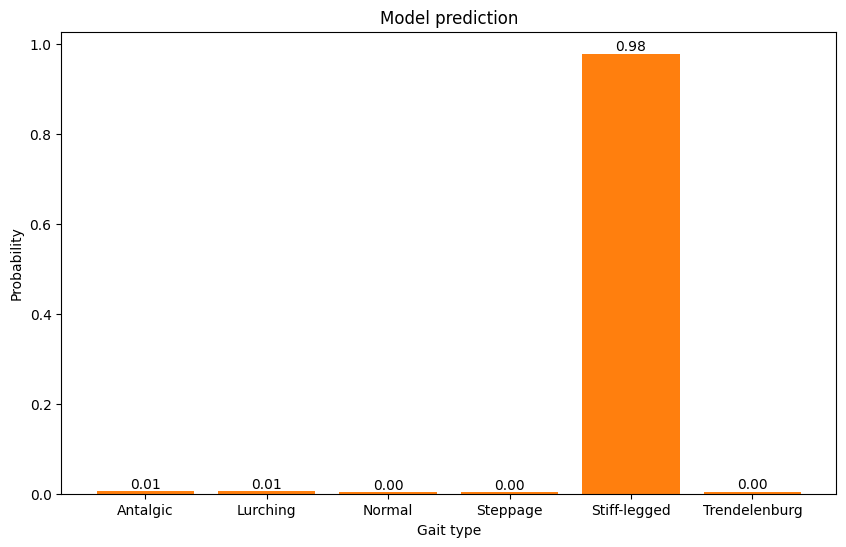


The predected label from the model is: Stiff-legged 

The true label is: Stiff-legged
The prediction is correct.


In [ ]:
# compute predicted labels
model_input = sk_p_data_crop_flip[np.newaxis, :]

output_vector = step_3_model.predict(model_input, verbose=0)
predicted_label = name_gait[np.argmax(output_vector)]

plt.bar(name_gait, output_vector.reshape(-1))
plt.xlabel('Gait type')
plt.ylabel('Probability')
plt.title('Model prediction')
plt.grid(False)
plt.bar_label(plt.bar(name_gait, output_vector.reshape(-1)), fmt='%.2f')
plt.show()

print()
print('The predected label from the model is:', predicted_label, '\n')

if true_label== predicted_label:
    print('The true label is:', true_label)
    print('The prediction is correct.')
else:
    print('The model made an incorrect prediction. The correct label is:', true_label)